In [1]:
import pandas as pd
import requests
import numpy as np
from sklearn.linear_model import LinearRegression 
from datetime import timedelta
from datetime import datetime
import io
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.stats import t
from sklearn.cluster import DBSCAN
from outliers import smirnov_grubbs as grubbs
from scipy.optimize import curve_fit

In [2]:
#Import database
url = "http://btserver-lab10.polito.it/conn_info?csv=1"
s = requests.get(url).content
df1 = pd.read_csv(io.StringIO(s.decode('utf-8')), sep=",")

#Set up the array 
df1.columns = ['ID1','ID2','MAC2','rssi','ismobile','timestamp','milliseconds']
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1.dtypes

ID1                     object
ID2                     object
MAC2                    object
rssi                   float64
ismobile                  bool
timestamp       datetime64[ns]
milliseconds             int64
dtype: object

In [4]:
#Function for means, variance...
def st_values(l):
    size = len(l)
    if size >= 25:
        #Normal distribution
        return norm.fit(l),'normal'
    if size < 25 and size >= 5:
        #T-STUDENT DISTR
        return t.fit(l),'t'
    if size < 5:
        return None
def append_dict(dic,distance,st):
    dic['distance'].append(distance)
    dic['type'].append(st[1][0])
    dic['mean'].append(st[0][1])
    dic['std'].append(st[0][2])

def distance_by_rssi(x,a):
    return np.power(10,-(x-a)/(10*2)) 

In [5]:
error = []
values = []
# lm = LinearRegression(n_jobs = 5)

In [6]:
#Load Json Data
with open('experiments.json') as json_data:
    experiments = json.load(json_data)
experiment = experiments[4]
start_dates = experiment['dates']
devices = experiment['devices']
interval = experiment['interval']
distances = experiment['distances']

In [7]:
device1 = devices[0]
device2 = devices[1]

#Setting up the configuration
interval_s = timedelta(seconds = interval)
inverse_distances = distances.copy()
inverse_distances.reverse()

count_distances = len(distances)
#Define duration in seconds
duration = timedelta(seconds = interval * (count_distances-1))
values1 = []
values2 = []
lim = 30
lim_time = timedelta(seconds = 30)
for start_date in start_dates:
    start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S') 
    end = start + duration + lim_time
    start = start - lim_time
    #How they see the static devices the non static devices with time
    #Matrix where they see the non_static device
    dfs =  df1[(df1.timestamp >= start) & ((df1.timestamp) <=end )]
    #Matrix that represent how each static device see the non static device
    d1 = dfs[(dfs.ID1 == device1['id']) & (dfs.ID2 == device2['id'])]
    d2 = dfs[(dfs.ID1 == device2['id']) & (dfs.ID2 == device1['id'])]    
    rssi1 = d1['rssi'].tolist()
    rssi2 = d2['rssi'].tolist()
    mfs1 =  d1['milliseconds'].sub(start.timestamp()*1000).tolist()
    mfs2 =  d2['milliseconds'].sub(start.timestamp()*1000).tolist()
    values1.extend(np.column_stack((mfs1,rssi1)))
    values2.extend(np.column_stack((mfs2,rssi2)))

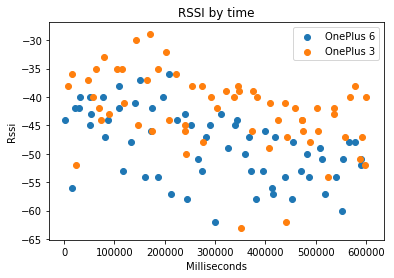

In [8]:
np1 = np.array(values1)
np2 = np.array(values2)
#How static devices see non static device depending of time
fig = plt.plot()
plt.title("RSSI by time")
plt.xlabel('Milliseconds')
plt.ylabel('Rssi')
p1 = plt.scatter(np1[:,0],np1[:,1])
p2 = plt.scatter(np2[:,0],np2[:,1])
#p3 = plt.plot(mfs1,test_model1)
#p3 = plt.plot(mfs2,test_model2)
p1.set_label(device1['name'])
p2.set_label(device2['name'])
plt.legend()
plt.show()

In [9]:
#Transform to dataframe
dtnp1 = pd.DataFrame({'milliseconds':np1[:,0],'rssi':np1[:,1]})
dtnp2 = pd.DataFrame({'milliseconds':np2[:,0],'rssi':np2[:,1]})

list1_dist = []
list2_dist = []
revers_distances = distances.copy()
revers_distances.reverse()

#Convert times to distances
for i in range(0,len(distances)):
    start_point = interval * i * 1000
    if i != 0:
        start_point = start_point + 1000*lim
    
    end_point = start_point + interval * 1000
    if i == 0:
        end_point = end_point + 1000 * lim
        
    if i == len(distances)-1: 
        end_point = end_point + 1000*lim

    
    #For device at 0 meters
    dt1_interval = dtnp1[(dtnp1.milliseconds >= start_point) & (dtnp1.milliseconds <= end_point)].rssi.unique().tolist()
    if(len(dt1_interval)>0):
        for rssi in dt1_interval:
            list1_dist.append(np.array([distances[i],rssi]))
                
    dt2_interval = dtnp2[(dtnp2.milliseconds >= start_point) & (dtnp2.milliseconds <= end_point)].rssi.unique().tolist()
    if(len(dt2_interval)>0):
        for rssi in dt2_interval:
            list2_dist.append(np.array([revers_distances[i],rssi]))
list1_dist=np.array(list1_dist)
list2_dist=np.array(list2_dist)

In [10]:
#For boxplot
bxdt_1 = pd.DataFrame({'distance':  list1_dist[:,0], 'rssi' : list1_dist[:,1]})
bxdt_2 = pd.DataFrame({'distance':  list2_dist[:,0], 'rssi' : list2_dist[:,1]})

bx_1 = []
bx_2 = []

rm_out1 = []
rm_out2 = []

for distance in distances:
    bx_1.append(bxdt_1[bxdt_1.distance == (distance)].rssi.tolist())
    bx_2.append(bxdt_2[bxdt_2.distance == (distance)].rssi.tolist())  

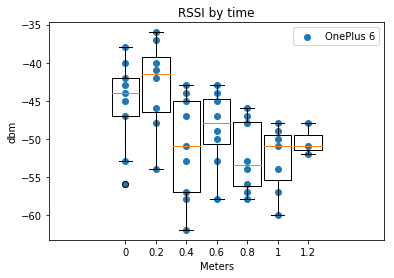

In [11]:
#Rssi by distance
fig = plt.plot()
fig = plt.plot()
plt.title("RSSI by time")
plt.xlabel('Meters')
plt.ylabel('dbm')
p1 = plt.scatter(list1_dist[:,0],list1_dist[:,1])
p3 = plt.boxplot(bx_1,positions = distances )
p1.set_label(device1['name'])
plt.legend()
plt.legend(loc='best')
plt.show()

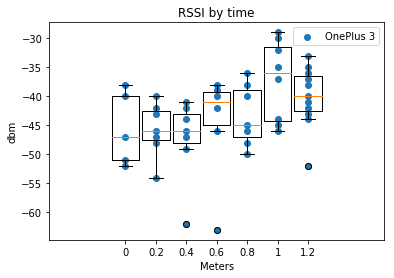

In [12]:
#Rssi by distance
fig = plt.plot()
fig = plt.plot()
plt.title("RSSI by time")
plt.xlabel('Meters')
plt.ylabel('dbm')
p2 = plt.scatter(list2_dist[:,0],list2_dist[:,1])
p3 = plt.boxplot(bx_2,positions = distances)
p2.set_label(device2['name'])
plt.legend()
plt.legend(loc='best')
plt.show()

In [13]:
#Calculate means, avergaes ...
dt1_distances = pd.DataFrame({'distance' : list1_dist[:,0], 'rssi' : list1_dist[:,1]})
dt2_distances = pd.DataFrame({'distance' : list2_dist[:,0], 'rssi' : list2_dist[:,1]})

dic1 = {'distance' : [], 'mean' : [], 'std' : [], 'type' : []}
dic2 = {'distance' : [], 'mean' : [], 'std' : [], 'type' : []}

for distance in distances:
    l1 = dt1_distances[dt1_distances.distance == distance].rssi.unique().tolist()
    l2 = dt2_distances[dt2_distances.distance == distance].rssi.unique().tolist()    
    st1 = st_values(l1)
    st2 = st_values(l2)
    if(st1 != None):
        append_dict(dic1,distance,st1)
    if(st2 != None):
        append_dict(dic2,distance,st2)

dt1_st = pd.DataFrame(dic1)
dt2_st = pd.DataFrame(dic2)

In [180]:
#Removing outliers
rm1 = []
rm2 = []
for distance in distances:
    l1 = dt1_distances[dt1_distances.distance == distance]['rssi'].tolist()
    l2 = dt2_distances[dt2_distances.distance == distance]['rssi'].tolist()    
    if len(l1) > 0:
        results = grubbs.test(l1,1)
        for result in results:
            rm1.append([distance,result])
    if len(l2) > 0:
        results = grubbs.test(l2,1)
        for result in results:
            rm2.append([distance, result])
rm1 = np.array(rm1)
rm2 =np.array(rm2)

[-55.13773073]


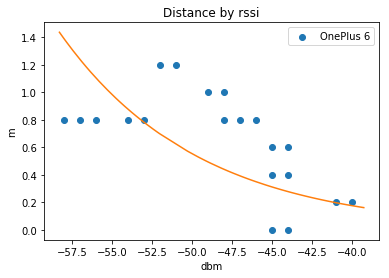

In [211]:
#How does the function fit
fit1, params1 = curve_fit(distance_by_rssi,rm1[:,1],rm1[:,0])
arr = np.random.uniform(low = min(rm1[:,1]-1), high=max(rm1[:,1]+1), size=(100,))
arr.sort()
dfit1 = distance_by_rssi(arr,*fit1)
print(fit1)
fig = plt.plot()
plt.title("Distance by rssi")
plt.ylabel('m')
plt.xlabel('dbm')

p1 = plt.scatter(rm1[:,1],rm1[:,0])
p1.set_label(device1['name'])
plt.plot(arr,dfit1,color='C1')

plt.legend()
plt.legend(loc='best')
plt.show()
dfit1 = distance_by_rssi(rm1[:,1],*fit1)

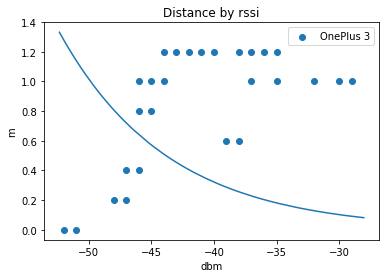

In [212]:
#How does the function fit
fit2, params2 = curve_fit(distance_by_rssi,rm2[:,1],rm2[:,0])
arr = np.random.uniform(low = min(rm2[:,1]-1), high=max(rm2[:,1]+1), size=(100,))
arr.sort()
dfit2 = distance_by_rssi(arr,*fit2)
fig = plt.plot()
plt.title("Distance by rssi")
plt.ylabel('m')
plt.xlabel('dbm')
p1 = plt.scatter(rm2[:,1],rm2[:,0])
p1.set_label(device2['name'])
plt.plot(arr,dfit2,color='C1')
plt.legend()
plt.legend(loc='best')
plt.show()
dfit2 = distance_by_rssi(rm2[:,1],*fit2)

20 20


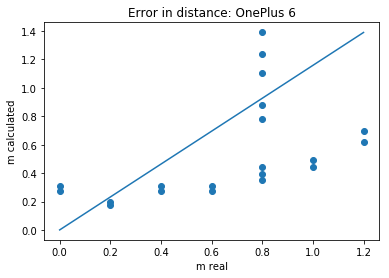

In [213]:
#Optimize distance vs distance(
dig_line = np.array([[0,0],[max(rm1[:,0]),max(dfit1)]])

print(len(rm1[:,0]), len(dfit1))
fig = plt.plot()
plt.title("Error in distance: " + device1['name'])
plt.ylabel('m calculated')
plt.xlabel('m real')
p1 = plt.scatter(rm1[:,0],dfit1)
p2 = plt.plot(dig_line[:,0],dig_line[:,1])
plt.show()

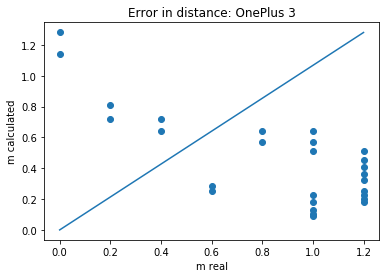

In [214]:
#Optimize distance vs distance(
dig_line = np.array([[0,0],[max(rm2[:,0]),max(dfit2)]])

fig = plt.plot()
plt.title("Error in distance: " + device2['name'])
plt.ylabel('m calculated')
plt.xlabel('m real')
p1 = plt.scatter(rm2[:,0],dfit2)
p2 = plt.plot(dig_line[:,0],dig_line[:,1])
plt.show()